In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
import random
import os

KNN classifier retrained successfully with moderator embeddings.


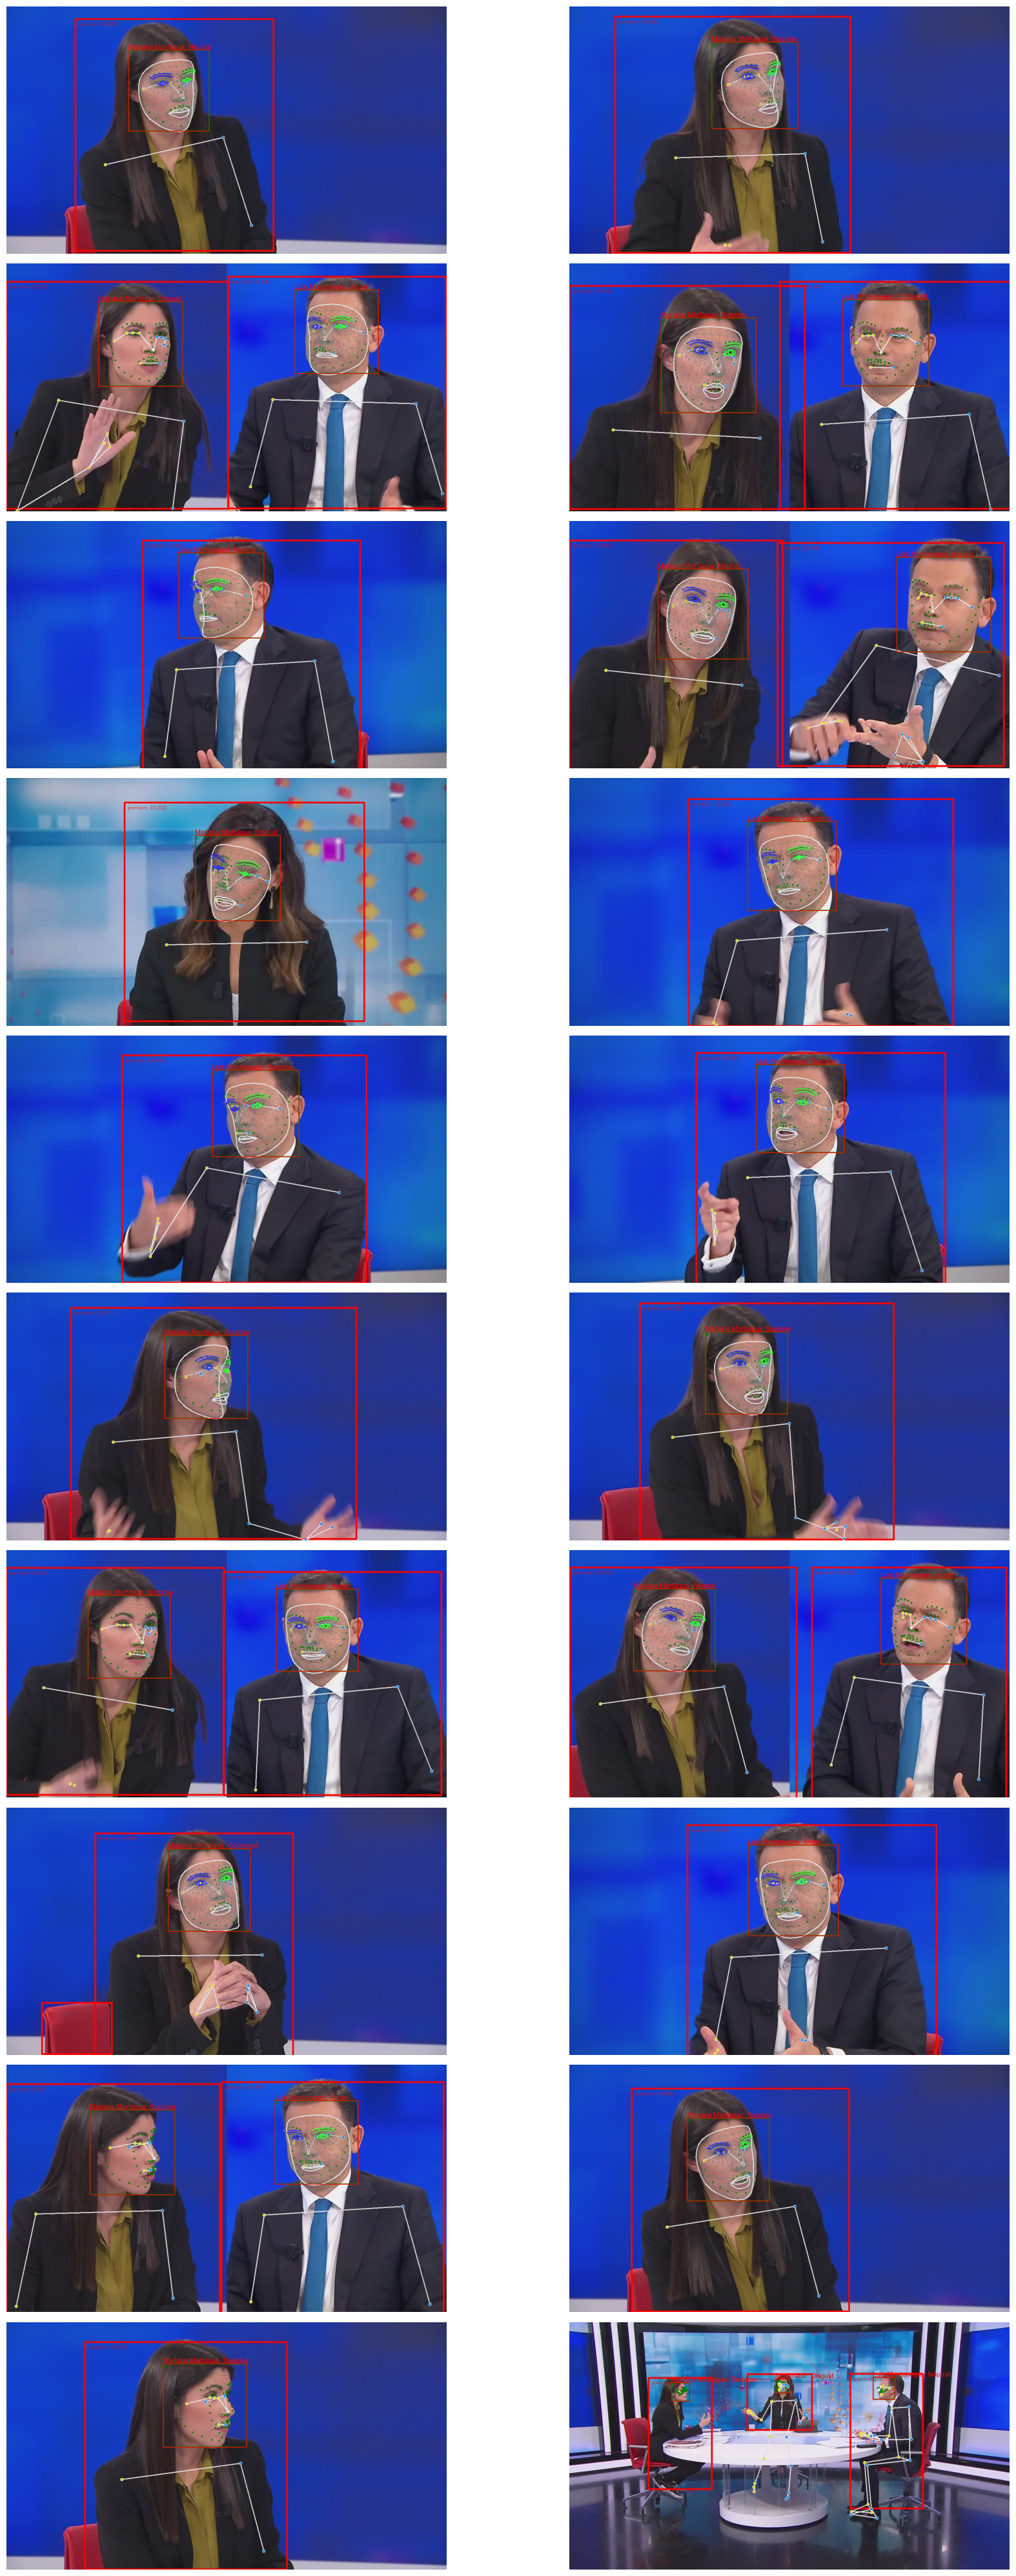

In [74]:

video = 'ad-be'

# Function to check if a face is the interpreter (all coordinates in the bottom right corner)
def is_interpreter(location, image_size):
    img_width, img_height = image_size
    x1, x2, y1, y2 = location
    return (x2 > 250 and y2 > 250 and x1 > 1000 and y1 > 1000)

# Load the reference embeddings from the text files
def load_reference_embeddings(file_path):
    embeddings = []
    with open(file_path, 'r') as file:
        for line in file:
            embedding = list(map(float, line.strip().strip('[]').split(',')))
            embeddings.append(embedding)
    return np.array(embeddings)

# Load embeddings for Luis Montenegro and Mariana Mortágua
embeddings_montenegro = load_reference_embeddings('Luis Montenegro.txt')
embeddings_mortagua = load_reference_embeddings('Mariana Mortagua.txt')

# Create labels for the embeddings
labels_montenegro = [1] * len(embeddings_montenegro)
labels_mortagua = [2] * len(embeddings_mortagua)

# Combine the embeddings and labels
ref_embeddings = np.vstack([embeddings_montenegro, embeddings_mortagua])
ref_labels = np.array(labels_montenegro + labels_mortagua)

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn.fit(ref_embeddings, ref_labels)

# Load the debate pickle file
with open(f'processed/{video}.pkl', 'rb') as file:
    debate_data = pickle.load(file)

# Function to pad or truncate embeddings to a fixed size
def pad_or_truncate(embedding, length):
    if len(embedding) > length:
        return embedding[:length]
    elif len(embedding) < length:
        return np.pad(embedding, (0, length - len(embedding)), 'constant')
    else:
        return embedding

embedding_dim = 128  # Dimension of the embeddings in the debate data

# Initialize counters and storage for moderator embeddings
emotion_counts = defaultdict(lambda: defaultdict(int))
appearance_counts = defaultdict(int)
moderator_embeddings = []

# First pass: Identify and store moderator embeddings from frames with exactly three people
for i in range(len(debate_data)):
    fer_info = debate_data.iloc[i]['fer']
    img_size = (1280, 720)  # Use a fixed size for images if dimensions are not available
    filtered_fer_info = [face for face in fer_info if not is_interpreter(face['location'], img_size)]

    if len(filtered_fer_info) == 3:
        filtered_fer_info.sort(key=lambda face: face['location'][0])
        moderator_embedding = pad_or_truncate(filtered_fer_info[1]['embedding'], embedding_dim)
        moderator_embeddings.append(moderator_embedding)

# Train the KNN classifier for the moderator
if moderator_embeddings:
    labels_moderator = [3] * len(moderator_embeddings)
    all_embeddings = np.vstack([ref_embeddings, np.vstack(moderator_embeddings)])
    all_labels = np.array(list(ref_labels) + labels_moderator)

    knn.fit(all_embeddings, all_labels)
    print("KNN classifier retrained successfully with moderator embeddings.")
else:
    print("No frames with exactly three people were found to identify moderator embeddings.")

# Function to annotate images with names and emotions using FER info and KNN labels
def annotate_image_with_names(image_path, fer_info, knn):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    img_width, img_height = img.size
    font = ImageFont.truetype("arial.ttf", 20)  # Specify font size

    # Filter out the interpreter (assumed to be in the bottom right corner)
    filtered_fer_info = [face for face in fer_info if not is_interpreter(face['location'], (img_width, img_height))]
    
    if len(filtered_fer_info) == 3:
        # Assign Mariana Mortágua, Moderator, and Luis Montenegro
        filtered_fer_info.sort(key=lambda face: face['location'][0])  # Sort by x1 coordinate (left to right)
        person_names = ["Mariana Mortágua", "Moderator", "Luis Montenegro"]
        labels = [2, 3, 1]
        for face_info, person_name, label in zip(filtered_fer_info, person_names, labels):
            x1, x2, y1, y2 = face_info['location']
            width = abs(x2 - x1)
            height = abs(y2 - y1)
            x = min(x1, x2)
            y = min(y1, y2)
            
            # Create a rectangle patch
            draw.rectangle([x, y, x + width, y + height], outline="red", width=2)
            emotion = face_info['emotion']
            draw.text((x, y - 20), f"{person_name}: {emotion}", fill="red", font=font)
    else:
        for face_info in filtered_fer_info:
            x1, x2, y1, y2 = face_info['location']
            width = abs(x2 - x1)
            height = abs(y2 - y1)
            x = min(x1, x2)
            y = min(y1, y2)
            
            # Create a rectangle patch
            draw.rectangle([x, y, x + width, y + height], outline="red", width=2)
            
            # Predict the person
            embedding = pad_or_truncate(face_info['embedding'], embedding_dim)
            label = knn.predict([embedding])[0]
            if label == 1:
                person_name = "Luis Montenegro"
            elif label == 2:
                person_name = "Mariana Mortágua"
            elif label == 3:
                person_name = "Moderator"
            else:
                person_name = "Unknown"

            emotion = face_info['emotion']
            draw.text((x, y - 20), f"{person_name}: {emotion}", fill="red", font=font)
    
    return img

# Process the debate data and save annotated images
annotated_images = []
for i in range(len(debate_data)):
    fer_info = debate_data.iloc[i]['fer']
    img_path = f"videos/{video}/{debate_data.iloc[i]['filename']}"  # Adjust the path based on your directory structure
    annotated_img = annotate_image_with_names(img_path, fer_info, knn)
    annotated_images.append(annotated_img)

# Display 20 random annotated images in the terminal (2 images per row)
sampled_images = random.sample(annotated_images, 20)
fig, axs = plt.subplots(10, 2, figsize=(20, 40))  # 10 rows, 2 images per row
for i, img in enumerate(sampled_images):
    row = i // 2
    col = i % 2
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()

## Plots

In [1]:
# Process the debate data for emotion and appearance counts
for i in range(len(debate_data)):
    fer_info = debate_data.iloc[i]['fer']
    img_size = (1280, 720) 
    filtered_fer_info = [face for face in fer_info if not is_interpreter(face['location'], img_size)]

    if len(filtered_fer_info) == 3:
        filtered_fer_info.sort(key=lambda face: face['location'][0])
        labels = [2, 3, 1]
    else:
        labels = [knn.predict([pad_or_truncate(face_info['embedding'], embedding_dim)])[0] for face_info in filtered_fer_info]

    for face_info, label in zip(filtered_fer_info, labels):
        if label in [1, 2]:  # Only consider Luis Montenegro and Mariana Mortágua
            person_name = "Luis Montenegro" if label == 1 else "Mariana Mortágua"
            emotion = face_info['emotion']
            emotion_counts[person_name][emotion] += 1
            appearance_counts[person_name] += 1

# Convert emotion counts to a DataFrame for plotting
emotion_df = pd.DataFrame(emotion_counts).fillna(0)

# Plot the emotion counts
plt.figure(figsize=(12, 8))
emotion_df.plot(kind='bar', width=0.8)
plt.title('Emotion Counts for Each Candidate')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.legend(title='Person')
plt.show()

# Plot the appearance counts
plt.figure(figsize=(8, 6))
plt.bar(appearance_counts.keys(), appearance_counts.values(), color=['blue', 'green'])
plt.title('Appearance Counts for Each Candidate')
plt.xlabel('Person')
plt.ylabel('Count')
plt.show()

NameError: name 'debate_data' is not defined

In [78]:
import os
import pandas as pd
import re
from collections import defaultdict

# Load all the data once and process it to avoid redundancy
processed_dir = 'processed'

# Define channel identification rules
channel_keywords = {
    "CNN": r"cnn|imagenscnn",  # Using word boundary to match 'cnn' exactly, or the specific term
    "RTP3": r"=3",
    "SIC Noticias": r"sic|debates",     # Matching 'sic' as a whole word or 'debates'
    "TVI": r"frenteafrente|tvi|decisao24|decisao|@vi|deusio24"  # Matching the exact phrase or 'tvi'
}

def identify_channel(data, thresholds):
    channel_counts = defaultdict(int)

    for framenumber in range(len(data)):
        texts = data.iloc[framenumber]['text']
        for text in texts:
            text_cleaned = text.replace(" ", "").lower()

            for channel, pattern in channel_keywords.items():
                if re.search(pattern, text_cleaned):
                    channel_counts[channel] += 1
                    if channel_counts[channel] > thresholds[channel]:
                        return channel

    # Determine which channel has the highest count if no single channel surpasses its threshold
    if channel_counts:
        max_channel = max(channel_counts, key=channel_counts.get)
        if channel_counts[max_channel] > 0:
            return max_channel
    return "SIC Noticias"

# Thresholds for channel identification, determined empirically or via a heuristic
thresholds = {
    "CNN": 200,
    "RTP3": 500,
    "SIC Noticias": 50,
    "TVI": 50
}

# Analyze each video file
data_path = os.path.join(processed_dir, file)
data = pd.read_pickle(data_path)    
channel = identify_channel(data, thresholds)
print(f"Video {file}: {channel}")


Video ad-be.pkl: SIC Noticias


## Fully automated

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
import os
import re

# Initialize global variables to collect statistics across all debates
global_emotion_counts = defaultdict(lambda: defaultdict(int))
global_appearance_counts = defaultdict(int)

# Function to check if a face is the interpreter (all coordinates in the bottom right corner)
def is_interpreter(location, image_size):
    img_width, img_height = image_size
    x1, y1, x2, y2 = location
    return (x2 > 250 and y2 > 250 and x1 > 1000 and y1 > 1000)

# Function to load reference embeddings from text files
def load_reference_embeddings(file_path):
    embeddings = []
    with open(file_path, 'r') as file:
        for line in file:
            embedding = list(map(float, line.strip().strip('[]').split(',')))
            embeddings.append(embedding)
    return np.array(embeddings)

# Function to identify debate participants from the filename
def identify_participants(debate_file):
    participants_map = {
        "ad": "Luis Montenegro",
        "be": "Mariana Mortagua",
        "il": "Rui Rocha",
        "pan": "Ines Real",
        "chega": "Andre Ventura",
        "cdu": "Paulo Raimundo",
        "ps": "Pedro Nuno Santos",
        "livre": "Rui Tavares"
    }
    debate_parties = re.findall(r'\b\w+\b', debate_file.lower())
    participants = [participants_map[party] for party in debate_parties if party in participants_map]
    return participants

# Function to process debate data and generate statistics
def process_debate(debate_file, ref_embeddings, ref_labels, candidate1, candidate2):
    print(f"Processing debate file: {debate_file}")
    with open(debate_file, 'rb') as file:
        debate_data = pickle.load(file)

    knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
    knn.fit(ref_embeddings, ref_labels)

    embedding_dim = 128
    emotion_counts = defaultdict(lambda: defaultdict(int))
    appearance_counts = defaultdict(int)
    emotion_vectors = defaultdict(list)
    moderator_embeddings = []

    for i in range(len(debate_data)):
        fer_info = debate_data.iloc[i]['fer']
        img_size = (1280, 720)
        filtered_fer_info = [face for face in fer_info if not is_interpreter(face['location'], img_size)]

        if len(filtered_fer_info) == 3:
            filtered_fer_info.sort(key=lambda face: face['location'][0])
            moderator_embedding = pad_or_truncate(filtered_fer_info[1]['embedding'], embedding_dim)
            moderator_embeddings.append(moderator_embedding)

    if moderator_embeddings:
        labels_moderator = [3] * len(moderator_embeddings)
        all_embeddings = np.vstack([ref_embeddings, np.vstack(moderator_embeddings)])
        all_labels = np.array(list(ref_labels) + labels_moderator)
        knn.fit(all_embeddings, all_labels)

    for i in range(len(debate_data)):
        fer_info = debate_data.iloc[i]['fer']
        img_size = (1280, 720)
        filtered_fer_info = [face for face in fer_info if not is_interpreter(face['location'], img_size)]

        if len(filtered_fer_info) == 3:
            filtered_fer_info.sort(key=lambda face: face['location'][0])
            labels = [2, 3, 1]
        else:
            labels = [knn.predict([pad_or_truncate(face_info['embedding'], embedding_dim)])[0] for face_info in filtered_fer_info]

        for face_info, label in zip(filtered_fer_info, labels):
            if label in [1, 2]:
                person_name = candidate1 if label == 1 else candidate2
                emotion = face_info['emotion']
                emotion_counts[person_name][emotion] += 1
                appearance_counts[person_name] += 1
                emotion_vectors[person_name].append(emotion)

    return emotion_counts, appearance_counts, emotion_vectors

# Function to pad or truncate embeddings to a fixed size
def pad_or_truncate(embedding, length):
    if len(embedding) > length:
        return embedding[:length]
    elif len(embedding) < length:
        return np.pad(embedding, (0, length - len(embedding)), 'constant')
    else:
        return embedding

# Process all debate files and generate statistics and plots
def process_all_debates():
    debate_files = [f for f in os.listdir('processed') if f.endswith('.pkl')]
    for debate_file in debate_files:
        participants = identify_participants(debate_file)
        if len(participants) < 2:
            continue  # Skip debates without clear two participants

        ref_embeddings, ref_labels = [], []
        for participant in participants:
            file_name = f"{participant.replace(' ', '_')}.txt"
            print(f"Loading reference embeddings for {participant} from {file_name}")
            embeddings = load_reference_embeddings(file_name)
            label = participants.index(participant) + 1
            ref_embeddings.append(embeddings)
            ref_labels.extend([label] * len(embeddings))
        
        ref_embeddings = np.vstack(ref_embeddings)
        ref_labels = np.array(ref_labels)

        debate_path = os.path.join('processed', debate_file)
        emotion_counts, appearance_counts, emotion_vectors = process_debate(debate_path, ref_embeddings, ref_labels, participants[0], participants[1])

        # Aggregate global statistics
        for person, emotions in emotion_counts.items():
            for emotion, count in emotions.items():
                global_emotion_counts[person][emotion] += count

        for person, count in appearance_counts.items():
            global_appearance_counts[person] += count

        # Convert emotion counts to a DataFrame for plotting
        emotion_df = pd.DataFrame(emotion_counts).fillna(0)

        # Plot and save the emotion counts for the debate
        plt.figure(figsize=(12, 8))
        emotion_df.plot(kind='bar', width=0.8)
        plt.title(f'Emotion Counts for Each Candidate in {debate_file}')
        plt.xlabel('Emotion')
        plt.ylabel('Count')
        plt.legend(title='Person')
        plt.savefig(f'emotion_counts_{debate_file}.png')
        plt.close()

        # Plot and save the appearance counts for the debate
        plt.figure(figsize=(8, 6))
        plt.bar(appearance_counts.keys(), appearance_counts.values(), color=['blue', 'green'])
        plt.title(f'Appearance Counts for Each Candidate in {debate_file}')
        plt.xlabel('Person')
        plt.ylabel('Count')
        plt.savefig(f'appearance_counts_{debate_file}.png')
        plt.close()

# Function to plot global statistics
def plot_global_statistics():
    # Convert global emotion counts to a DataFrame for plotting
    emotion_dfs = []
    for candidate, emotions in global_emotion_counts.items():
        df = pd.DataFrame(emotions, index=[candidate])
        emotion_dfs.append(df)
    emotion_df = pd.concat(emotion_dfs).fillna(0)

    # Plot the global emotion counts for each candidate
    plt.figure(figsize=(12, 8))
    emotion_df.plot(kind='bar', width=0.8)
    plt.title('Global Emotion Counts for Each Candidate Across All Debates')
    plt.xlabel('Candidate')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Emotion')
    plt.tight_layout()
    plt.show()

    # Convert global appearance counts to a DataFrame for plotting
    appearance_df = pd.DataFrame(list(global_appearance_counts.items()), columns=['Candidate', 'Count'])

    # Plot the global appearance counts for each candidate
    plt.figure(figsize=(12, 8))
    plt.bar(appearance_df['Candidate'], appearance_df['Count'], color='skyblue')
    plt.title('Global Appearance Counts for Each Candidate Across All Debates')
    plt.xlabel('Candidate')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run the processing and plotting functions
process_all_debates()
plot_global_statistics()


Loading reference embeddings for Luis Montenegro from Luis_Montenegro.txt
Loading reference embeddings for Mariana Mortagua from Mariana_Mortagua.txt
Processing debate file: processed\ad-be.pkl
Loading reference embeddings for Luis Montenegro from Luis_Montenegro.txt
Loading reference embeddings for Paulo Raimundo from Paulo_Raimundo.txt
Processing debate file: processed\ad-cdu.pkl
Loading reference embeddings for Luis Montenegro from Luis_Montenegro.txt
Loading reference embeddings for Andre Ventura from Andre_Ventura.txt
Processing debate file: processed\ad-chega.pkl
Loading reference embeddings for Luis Montenegro from Luis_Montenegro.txt
Loading reference embeddings for Rui Rocha from Rui_Rocha.txt
Processing debate file: processed\ad-il.pkl
Loading reference embeddings for Luis Montenegro from Luis_Montenegro.txt
Loading reference embeddings for Rui Tavares from Rui_Tavares.txt
Processing debate file: processed\ad-livre.pkl
Loading reference embeddings for Luis Montenegro from Lui

FileNotFoundError: [Errno 2] No such file or directory: 'Andre_Ventura.txt'

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>